In [1]:
import numpy as np
from scipy.stats import t, binom, norm
from scipy.special import logsumexp, gamma, hyp1f1
import torch
import itertools
import matplotlib.pyplot as plt

# Bayesian Privacy Accountant
Bayesian Privacy Accountant 是一种用来分析和计算差分隐私机制下隐私损失的工具，提供了一种灵活且精确的方法来量化和跟踪隐私损失，特别是在处理涉及多次查询或复合机制时。

实现 Bayesian Privacy Accountant 的步骤：
1.	定义隐私损失随机变量。
2.	计算每次查询的隐私损失分布。
3.	累积隐私损失。
4.	从隐私损失分布中推断总体的差分隐私参数。

In [2]:
def scaled_renyi_gaussian(alphas, left_dist, right_dist):
    """Computing scaled Renyi divergence between pairs of Gaussian distributions (with the same variance).

    Args:
        alphas (number): Order of the Renyi divergence.
        left_dist (tuple or array): Parameters of the left Gaussians (mu_left [n_samples * n_features], sigma [scalar]).
        right_dist (tuple or array): Parameters of the right Gaussians (mu_right [n_samples * n_features], sigma [scalar]).

    Returns:
        array: Scaled Renyi divergences
    """
    lmu, lsigma = left_dist
    rmu, rsigma = right_dist
    distances = lmu - rmu
    if np.isscalar(distances):
        distances = torch.tensor(distances)
    distances = torch.norm(distances, p=2, dim=-1).view(-1).to(alphas)

    return torch.ger(distances**2, alphas * (alphas - 1) / (2 * lsigma**2))

class BayesianPrivacyAccountant:
    """Bayesian privacy accountant for Bayesian DP."""
    
    def __init__(self, powers=32, total_steps=1, scaled_renyi_fn=None, conf=1-1e-16, bayesianDP=True):
        """Creates BayesianPrivacyAccountant object.
            
        Args:
            power : number, required. 
                Order of the Renyi divergence used in accounting.
            total_steps : number, optional. Total number of privacy mechanism invocations envisioned. 
                Only needed if bayesianDP==True. Can be an upper bound.
            scaled_renyi_fn : function, required
                Function pointer to compute scaled Renyi divergence (defines privacy mechanism). 
                If None, sampled Gaussian mechanism is assumed.
            conf : number, required
                Required confidence level in Bayesian accounting (only used if bayesianDP==True).
            bayesianDP : boolean, optional
                Return Bayesian DP bound. If False, returns the classical DP bound.
        """
        self.powers = powers
        self.holder_correction = total_steps
        self.scaled_renyi_fn = scaled_renyi_gaussian if scaled_renyi_fn is None else scaled_renyi_fn
        self.conf = conf
        self.bayesianDP = bayesianDP
        # total accumulated privacy costs (log of moment generating function) per Renyi order
        self.privacy_cost = np.zeros_like(self.powers, dtype=np.float_)
        # total accumulated confidence of Bayesian estimator (eventually, incorporated in delta)
        self.logconf = 0
        # history of minimum privacy cost per iteration
        self.history = []
        self.steps_accounted = 0
    
    
    def get_privacy(self, target_eps=None, target_delta=None):
        """Computes privacy parameters (eps, delta).
            
        Args:
            target_eps : number, required. Target epsilon.
            target_delta : number, required. Target delta.
            
        Returns:
            tuple: A pair (eps, delta)
        """
        if (target_eps is None) and (target_delta is None):
            raise ValueError("Both parameters cannot be None")
        if (target_eps is not None) and (target_delta is not None):
            raise ValueError("One of the parameters has to be None")
        if self.steps_accounted > self.holder_correction:
            warnings.warn(
                f"Accountant invoked for {self.steps_accounted} steps, "
                f"but corrected only for {self.holder_correction}. "
                "Privacy may be underestimated due to incorrect parameters in Hölder's inequality. "
                "To fix the issue, specify the total number of times a privacy mechanism will be "
                "invoked in 'total_steps' when creating BayesianPrivacyAccountant."
            )
        if target_eps is None:
            return np.min((self.privacy_cost - np.log(target_delta - (1 - np.exp(self.logconf)))) / self.powers), target_delta

        else:
            return target_eps, np.min(np.exp(self.privacy_cost - self.powers * target_eps))
    
    
    def accumulate(self, ldistr, rdistr, q=1, steps=1):
        """Accumulates privacy cost for a given number of steps.
            
        Args:
            ldistr : tuple or array, required
                Parameters of the left distribution (i.e., imposed by D).
            rdistr : tuple or array, required
                Parameters of the right distribution (i.e., imposed by D').
            q : number, required
                Subsampling probability (for subsampled mechanisms).
            steps : number, required
                Number of steps/invocations of the privacy mechanism.

        Returns:
            tuple : Total privacy cost and log confidence.
        """
        if np.isscalar(self.powers):
            bdp = self._compute_bdp(self.powers, self.scaled_renyi_fn, ldistr, rdistr, q, steps)
        else:
            bdp = np.array([self._compute_bdp(power, self.scaled_renyi_fn, ldistr, rdistr, q, steps) 
                                     for power in self.powers])

        self.privacy_cost += bdp
        self.history += [np.min(self.privacy_cost)]
        self.logconf += np.log(self.conf) if self.bayesianDP else 0
        self.steps_accounted += steps
        return self.history[-1], self.logconf

    
    def _compute_bdp(self, power, scaled_renyi_fn, ldistr, rdistr, q, steps):
        """Compute privacy cost for a given number of steps.
            
        Args: 
            power : number, required
                Order of the Renyi divergence used in privacy cost computation.
            scaled_renyi_div_fn : function, required
                Function pointer to compute scaled Renyi divergence.
            ldistr : tuple or array, required
                Parameters of the left distribution (i.e., imposed by D).
            rdistr : tuple or array, required
                Parameters of the right distribution (i.e., imposed by D').
            q : number, required
                Subsampling probability (for subsampled mechanisms).
            steps : number, required
                Number of steps/invocations of the privacy mechanism.

        Returns:
            tuple : Total privacy cost and log confidence.
        """
        c_L = self._log_binom_expect(power + 1, q, scaled_renyi_fn, ldistr, rdistr)
        c_R = self._log_binom_expect(power + 1, q, scaled_renyi_fn, rdistr, ldistr)


        logmgf_samples = self.holder_correction * steps * torch.max(c_L, c_R).cpu().numpy()
        n_samples = np.size(logmgf_samples)

        if not self.bayesianDP:
            return logmgf_samples.item() / self.holder_correction

        if n_samples < 3:
            raise ValueError("Number of samples is too low for estimating privacy cost.")

        max_logmgf = np.max(logmgf_samples)
        log_mgf_mean = -np.log(n_samples) + logsumexp(logmgf_samples)
        if np.std(logmgf_samples) < np.finfo(np.float_).eps:
            warnings.warn("Variance of privacy cost samples is 0. Privacy estimate may not be reliable!")
            bdp = log_mgf_mean / self.holder_correction
        else:
            log_mgf_std = 0.5 * (2 * max_logmgf - np.log(n_samples) +\
                                 np.log(np.sum(np.exp(2 * logmgf_samples - 2 * max_logmgf) -\
                                               np.exp(2 * log_mgf_mean - 2 * max_logmgf))))
            log_conf_pentalty = np.log(t.ppf(q=self.conf, df=n_samples-1)) + log_mgf_std - 0.5 * np.log(n_samples - 1)
            bdp = logsumexp([log_mgf_mean, log_conf_pentalty]) / self.holder_correction
        
        return bdp
    
    
    def _log_binom_expect(self, n, p, scaled_renyi_fn, ldistr, rdistr):
        """Computes logarithm of expectation over binomial distribution with parameters (n, p).
            
        Args: 
            n : number, required
                Number of Bernoulli trials.
            p : number, required
                Probability of success.
            scaled_renyi_fn : function, required
                Function pointer to compute scaled Renyi divergence (inside Bernoulli expectation).
            ldistr : tuple or array, required
                Parameters of the left distribution (i.e., imposed by D).
            rdistr : tuple or array, required
                Parameters of the right distribution (i.e., imposed by D').

        Returns : 
            tuple : Logarithm of expectation of scaled_renyi_fn over binomial distribution.
        """
        k = torch.arange(n + 1, dtype=torch.float)
        log_binom_coefs = torch.tensor(binom.logpmf(k, n=n, p=p))


        scaled_renyi_value = scaled_renyi_fn(k, ldistr, rdistr)
        
        result = torch.logsumexp(log_binom_coefs + scaled_renyi_value, dim=1)

        return result

# Wasserstein Privacy Accountant

In [3]:
class WassersteinPrivacyAccountant:
	def __init__(self, order, steps_total, beta):
		"""Creating Wasserstein Privacy Accountant.

		Args: 
			orders: list or int
				The orders set for Wasserstein differential privacy.
			steps_total:
				Total iterations steps in Wasserstein differential privacy accountant.
			steps_accounted:
				Total accounted steps in Wasserstein differential privacy accountant.
			privacy_loss: 
				The privacy_loss of Wasserstein differential privacy.
		"""
		self.order = order
		self.steps_total = steps_total
		self.beta = beta
		self.privacy_loss = torch.zeros_like(torch.tensor(self.order), dtype = torch.float)
		self.history = []
		self.steps_accounted = 0

	def get_privacy(self, target_privacy=None, target_delta=None):
		"""Computes privacy parameters (epsilon, delta).
		
  		Args:
			target_privacy: float
				Target privacy budget
			target_failure:  float
				Taget failure probability

		Returns:
			tuple: (epsilon, delta)
		"""

		if (target_privacy is None) and (target_delta is None):
			raise ValueError("At least one of the two parameters should be defined.")
		if (target_privacy is not None) and (target_delta is not None):
			raise ValueError("Only one of the two parameters can be assigned to obtain the other.")
		if target_privacy is None:
			return torch.min(self.privacy_loss - np.log(target_delta)/self.beta).item(), target_delta
			#return torch.min(self.privacy_loss/self.beta), target_delta
		else:
			return target_privacy, self.beta * torch.exp(self.privacy_loss - target_privacy)


	def accumulate(self, lgrad, rgrad, scale_param, subsampling_rate, steps=1):
		"""Computing accumulative privacy loss under WDP.
            
        Args:
            lgrad : tensor, required
                One of the neiboring gradient tensor.
            rgrad : tensor, required
                Another of the neiboring gradient tensor.
            scale_param : float
            	Scale parameter of Gaussian distribution.
            subsampling_rate : float, required
                Sampling rate in DP-SGD.
    
        Returns:
        	tensor : Accumulative privacy loss under WDP.
        """
		wdp = self.compute_privacy_loss(
									lgrad = lgrad, 
									rgrad = rgrad,
									scale_param = scale_param,
									subsampling_rate = subsampling_rate,
									)

		self.privacy_loss += wdp
		self.history.append(self.privacy_loss)
		self.steps_accounted += steps
		return self.history[-1]

	def compute_privacy_loss(self, lgrad, rgrad, scale_param, subsampling_rate):
		"""Computing privacy loss under WDP.
            
        Args: 
            lgrad : tensor, required
                One of the neiboring gradient tensor.
            rgrad : tensor, required
                Another of the neiboring gradient tensor.
            scale_param : float
            	Scale parameter of Gaussian distribution.
            subsampling_rate : float, required
                Sampling rate in DP-SGD.
            
        Returns:
        	tensor : Privacy loss under WDP.
        """
		abs_moment = self.compute_absolute_moments(
										lgrad = lgrad, 
										rgrad = rgrad,
										scale_param = scale_param,
										subsampling_rate = subsampling_rate,
										)
		sum_moment = torch.sum(abs_moment)
		privacy_loss = torch.pow(sum_moment, 1/self.order)
  
		return torch.min(privacy_loss).item()

	def compute_absolute_moments(self, lgrad, rgrad, scale_param, subsampling_rate):
		"""Computing the absolute moments of a Gaussian distribution.
            
            Parameters
            ----------
            lgrad : tensor, required
                One of the neiboring gradient tensor.
            rgrad : tensor, required
                Another of the neiboring gradient tensor.

            scale_param : float
            	Scale parameter of Gaussian distribution.
            subsampling_rate : float, required
                Sampling rate in DP-SGD.
    
            
            Returns
            -------
            out : tensor
                The absolute moments of a Gaussian distribution.
        """
		
		if subsampling_rate > 1 or subsampling_rate < 0:
			raise ValueError("subsampling_rate should smaller than 1 and larger than 0.")

		coeff_of_val = (2 - 2*subsampling_rate + 2*pow(subsampling_rate, 2))
		sigma_square = pow(scale_param, 2)

		variance = coeff_of_val * sigma_square


		first_term = pow(2 * variance, self.order / 2)

		gamma_term = self.compute_gamma_function() / (np.sqrt(np.pi))

		grad_dist = self.compute_grad_norm(lgrad, rgrad)

		kummor_term = self.compute_kummor_confluent_hypergeometric_function(
					subsampling_rate = subsampling_rate, 
					grad_distance = grad_dist, 
					variance = variance, 
				)

		abs_moment = first_term * gamma_term * kummor_term

		# print('=*'*10, torch.min(abs_moment))

		return abs_moment



	def compute_gamma_function(self):
		z_param = (self.order + 1)/2 
		return gamma(z_param)



	def compute_kummor_confluent_hypergeometric_function(self, subsampling_rate, grad_distance, variance):
		"""
            Computing the norm of neighboring gradients.
            
            Parameters
            ----------
            subsampling_rate : float, required
                Sampling rate in DP-SGD.
            grad_distance : tensor, required
                The norm of neighboring gradients.
            variance : float
            	The variance of Gaussian noise in DP-SGD.
            
            Returns
            -------
            out : tensor
                A tensor represents the norm of the input neiboring gradients.
        """

		a_param = -self.order / 2

		b_param = 1/2
		
		q_square = pow(subsampling_rate, 2)
		d_t_square = torch.pow(grad_distance, 2)

		x_param = - (q_square * d_t_square) / (2 * variance)

		kummor = hyp1f1(a_param, b_param, x_param.cpu())

		return kummor



	def compute_grad_norm(self, lgrad, rgrad):
		"""
            Computing the norm of neighboring gradients.
            
            Parameters
            ----------
            lgrad : tensor, required
                One of the neiboring gradient tensor.
            rgrad : tensor, required
                Another of the neiboring gradient tensor.
            
            Returns
            -------
            out : tensor
                A tensor represents the norm of the input neiboring gradients.
        """

		grad_distance = lgrad - rgrad

		if not torch.is_tensor(grad_distance):
			grad_distance = torch.tensor(grad_distance)


		grad_distance = torch.norm(grad_distance, p=2, dim=-1).view(-1)

		# print('='*10, grad_distance.shape)

		return grad_distance

# 实验二

## 0.1 分位数

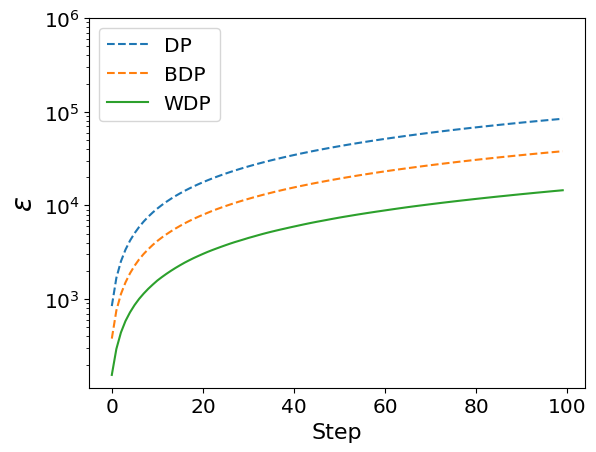

In [4]:
ma_eps = []
ba_eps = []
wa_eps = []
quant = 0.1
sigma = 0.2
plot_range = np.arange(100)

moment_accountant = BayesianPrivacyAccountant(powers=16, total_steps=plot_range[-1]+1, bayesianDP=False)
bayes_accountant = BayesianPrivacyAccountant(powers=16, total_steps=plot_range[-1]+1)
wasser_accountant = WassersteinPrivacyAccountant(order=16, steps_total=plot_range[-1]+1, beta=1)

for i in plot_range:
    grads = np.random.weibull(0.5, [50, 1000])
    C = np.quantile(np.linalg.norm(grads, axis=1), quant)
    grads /= np.maximum(1, np.linalg.norm(grads, axis=1, keepdims=True) / C)
    
    moment_accountant.accumulate(
        ldistr=(C*2, sigma * C ), 
        rdistr=(0, sigma * C),
        q=1/1000, 
        steps=1
    )
    ma_eps += [moment_accountant.get_privacy(target_delta=1e-5)[0]]
    
    
    pairs = list(zip(*itertools.combinations(torch.tensor(grads), 2)))
    bayes_accountant.accumulate(
        ldistr=(torch.stack(pairs[0]), sigma * C ), 
        rdistr=(torch.stack(pairs[1]), sigma * C ), 
        q=1/1000, 
        steps=1
    ) 
    ba_eps += [bayes_accountant.get_privacy(target_delta=1e-5)[0]]
    
    
    wasser_accountant.accumulate(
        scale_param = sigma * C ,
        subsampling_rate = 1/1000,
        lgrad = torch.stack(pairs[0]),
        rgrad = torch.stack(pairs[1]), 
    )
    wa_eps += [wasser_accountant.get_privacy(target_delta=1e-5)[0]]
    
plt.plot(plot_range, ma_eps, '--', label='DP')
plt.plot(plot_range, ba_eps, '--', label='BDP')
plt.plot(plot_range, wa_eps, label='WDP')
plt.xlabel(r'Step', fontsize=16)
plt.ylabel(r'$\varepsilon$', fontsize=20)
plt.xticks(fontsize=14.5)
plt.yticks(fontsize=14.5)
plt.yscale('log')
plt.ylim(top=1e6)
plt.legend(fontsize=14.5,loc=2)
plt.savefig('eps_step_{}q_noclip.pdf'.format(int(quant*100)), format='pdf', bbox_inches='tight')

## 0.5 分位数

<Figure size 640x480 with 0 Axes>

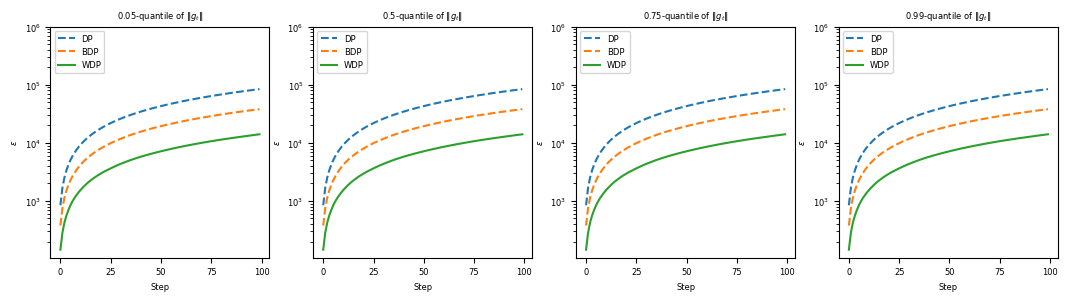

In [19]:
quants = [0.05, 0.5, 0.75, 0.99]
sigma = 0.2
plot_range = np.arange(100)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.figure(figsize=(13,3))

ma_epss = []
ba_epss = []
wa_epss = []
    
for it, quant in enumerate(quants):
    ma_eps = []
    ba_eps = []
    wa_eps = []
    
    moment_accountant = BayesianPrivacyAccountant(powers=16, total_steps=plot_range[-1]+1, bayesianDP=False)
    bayes_accountant = BayesianPrivacyAccountant(powers=16, total_steps=plot_range[-1]+1)
    wasser_accountant = WassersteinPrivacyAccountant(order=16, steps_total=plot_range[-1]+1, beta=1)

    for i in plot_range:
        grads = np.random.weibull(0.5, [50, 1000])
        C = np.quantile(np.linalg.norm(grads, axis=1), quant)
        grads /= np.maximum(1, np.linalg.norm(grads, axis=1, keepdims=True) / C)
        
        moment_accountant.accumulate(
            ldistr=(C*2, sigma * C ), 
            rdistr=(0, sigma * C),
            q=1/1000, 
            steps=1
        )
        ma_eps += [moment_accountant.get_privacy(target_delta=1e-5)[0]]
        
        
        pairs = list(zip(*itertools.combinations(torch.tensor(grads), 2)))
        bayes_accountant.accumulate(
            ldistr=(torch.stack(pairs[0]), sigma * C ), 
            rdistr=(torch.stack(pairs[1]), sigma * C ), 
            q=1/1000, 
            steps=1
        ) 
        ba_eps += [bayes_accountant.get_privacy(target_delta=1e-5)[0]]
        
        
        wasser_accountant.accumulate(
            scale_param = sigma * C ,
            subsampling_rate = 1/1000,
            lgrad = torch.stack(pairs[0]),
            rgrad = torch.stack(pairs[1]), 
        )
        wa_eps += [wasser_accountant.get_privacy(target_delta=1e-5)[0]]

        ma_epss.append(ma_eps)
        ba_epss.append(ba_eps)
        wa_epss.append(wa_eps)
        
    plt.subplot(1, 4, it+1)
    plt.plot(plot_range, ma_epss[it], '--', label='DP')
    plt.plot(plot_range, ba_epss[it], '--', label='BDP')
    plt.plot(plot_range, wa_epss[it], label='WDP')
    plt.xlabel(r'Step', fontsize=6)
    plt.ylabel(r'$\varepsilon$', fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.yscale('log')
    plt.ylim(top=1e6)
    plt.legend(fontsize=6,loc=2)
    plt.title("{}-quantile of $\Vert g_t\Vert$".format(quant), fontsize=6)

plt.savefig('exp2-result.pdf'.format(int(quant*100)), format='pdf', bbox_inches='tight')